In [ ]:
#transfer learning code adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob as glob
import pandas as pd
#importing required modules

In [36]:
test_dir = './test'
train_dir = './train'
val_dir = './valid'
#setting directories in this folder
print(test_dir)
print(train_dir)
print(val_dir)
#printing directories to be sure 
IMG_SIZE = (224, 224)
#setting resultion for later

./test
./train


In [37]:
batch_size = 150
#setting bach size
img_height = 224
img_width = 224
#setting height and width seperatly
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
val_dir,
seed=123,
#splitting training ds and testing ds with the same seed to it can be replicated
image_size=(img_height, img_width),
#setting image size
batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)
#checking class names and number of files 
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)
#repeating for test ds (needed later)

Found 13572 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'p

In [38]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#shuffling the data within the traning and validation sets
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#normalising the training dataset
image_batch, labels_batch = next(iter(normalized_ds))
#joining images with thier lables
first_image = image_batch[0]
#checking for normalisation of the RGB values in the image
print(np.min(first_image), np.max(first_image))
num_classes = 100
#setting number of classes to be predicted

0.0 1.0


In [39]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
include_top=False,
weights='imagenet')
#downloading resnet-50 and storing as 'base model'

In [40]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
#extracts features from image

(150, 7, 7, 2048)


In [41]:
base_model.trainable = False
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
#printing the model (frozen so not to overide weights)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [42]:
prediction_layer = tf.keras.layers.Dense(100)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)
#prediction layer set up for the number of classes

(150, 100)


In [43]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
#rescales to what the base model needs

In [44]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
#above are all the layers beign set up (x)
model = tf.keras.Model(inputs, outputs)
#defining the model
base_learning_rate = 0.01
#set learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
#compiling the model using sparse catagorical crossentropy for the loss function and accuracy
model.summary()
#printing the model 
len(model.trainable_variables)
initial_epochs = 3
#setting epochs
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
#printing baseline accuracy
history = model.fit(train_ds,
epochs=initial_epochs,
validation_data=val_ds)
#defining history as the history of the model being trained and thus starting the training 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

c:\Program Files\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 87ms/step - loss: 5.7638 - accuracy: 0.0040
initial loss: 5.76
initial accuracy: 0.00
Epoch 1/3
91/91 [==============================] - 12s 112ms/step - loss: 3.1948 - accuracy: 0.6383 - val_loss: 0.4780 - val_accuracy: 0.8760
Epoch 2/3
91/91 [==============================] - 10s 110ms/step - loss: 0.5215 - accuracy: 0.8826 - val_loss: 0.5963 - val_accuracy: 0.8680
Epoch 3/3
91/91 [==============================] - 10s 111ms/step - loss: 0.4578 - accuracy: 0.9011 - val_loss: 0.4981 - val_accuracy: 0.9040


In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#saving the metrics from the training history

In [46]:
base_model.trainable = False
base_model.summary()
#printing the total number of layers to inform layer unfreezing 
print("Number of layers in the base model: ", len(base_model.layers))
#setting the point to unfreeze
fine_tune_at = 140
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = True

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [47]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/100),
metrics=['accuracy'])
#compiile the model with the same metrics as earlier but devide the learning rate by 10 for the finetuning

c:\Program Files\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [48]:
fine_tune_epochs = 3
#setting finetune epochs
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
epochs=total_epochs,
initial_epoch=history.epoch[-1],
validation_data=val_ds
)
#fine tune

Epoch 3/6
91/91 [==============================] - 12s 117ms/step - loss: 0.1335 - accuracy: 0.9612 - val_loss: 0.3126 - val_accuracy: 0.9360
Epoch 4/6
91/91 [==============================] - 10s 113ms/step - loss: 0.0931 - accuracy: 0.9748 - val_loss: 0.2796 - val_accuracy: 0.9420
Epoch 5/6
91/91 [==============================] - 10s 112ms/step - loss: 0.0825 - accuracy: 0.9764 - val_loss: 0.2709 - val_accuracy: 0.9420
Epoch 6/6
91/91 [==============================] - 10s 110ms/step - loss: 0.0745 - accuracy: 0.9775 - val_loss: 0.2642 - val_accuracy: 0.9440


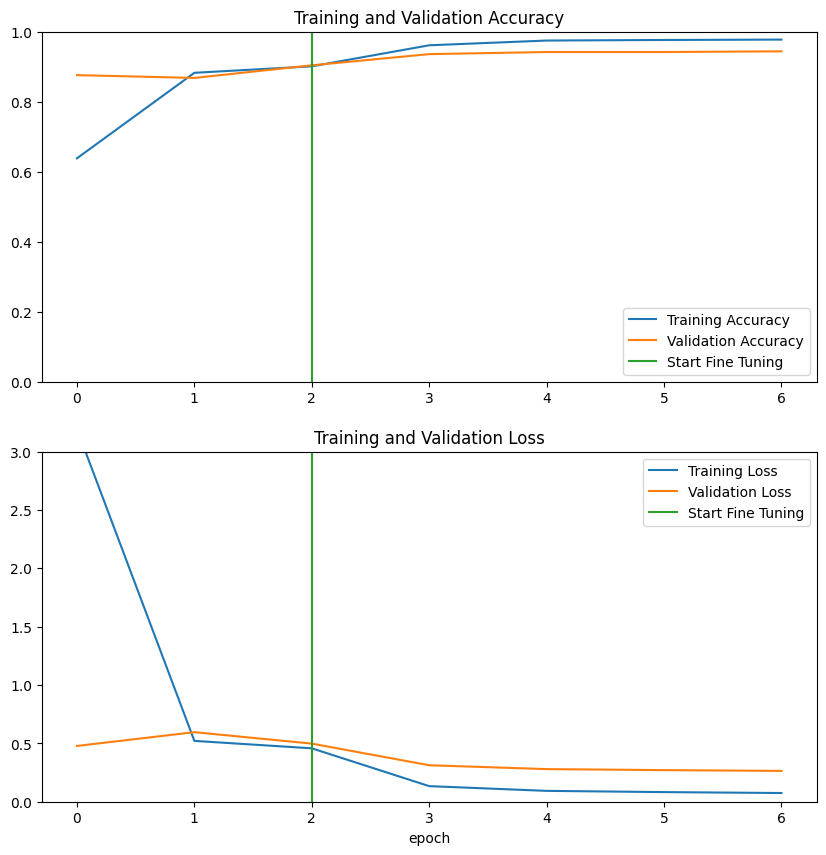

In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('.loss and accuracy resnet')
plt.show()
#print grapghs below


In [50]:
model.evaluate(test_dataset)
#evaluate on test DS

4/4 [==============================] - 1s 94ms/step - loss: 0.2317 - accuracy: 0.9520


[0.23166905343532562, 0.9520000219345093]

In [51]:
model.save('.resnet_model')
#save the to .resnet in the directory

INFO:tensorflow:Assets written to: .resnet_model\assets


INFO:tensorflow:Assets written to: .resnet_model\assets
